In [1]:
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from keras.models import Sequential, Model
from keras.engine.topology import Input
from keras.layers.core import Dense, Dropout, Activation,Reshape
from keras.layers import Conv1D, Conv2D, Flatten, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model
from keras import backend as K
import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.layers.core import Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

Using TensorFlow backend.


## Parameters

In [34]:
batch = 3
epochs = 3;
num_classes = 41;
input_Shape = (150,150)
num_train_samples = 800
num_test_samples = 200
model_name = 'short-long_skip'
# creates folder
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [2]:
os.listdir()
os.chdir('./Dataset/Segmentation/')
os.listdir()

['gt',
 'images',
 'labels_categorical',
 'label_colors.csv',
 'long_skip',
 'long_skipmy_weights.h5',
 'long_skip_model.png',
 'short_skip',
 'short_skipmy_weights.h5',
 'short_skip_model.png']

## Load Filenames

In [4]:
dataset = []
folder = "./images/"
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
for file in files:
    dataset.append(file)


In [5]:
dataset_labels = []
folder = "./labels_categorical/"
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
for file in files:
    dataset_labels.append(file)

## Split into Train and Test

In [7]:
x_train,x_test,y_train,y_test = train_test_split(dataset,dataset_labels,test_size = 0.2)

## Load Data

In [8]:
X_train = np.zeros((num_train_samples,input_Shape[0],input_Shape[1], 3 ))
for index,item in enumerate(x_train): 
    path = "./images/" + item
    img = plt.imread(path)
    new_img = cv2.resize(img,(int(input_Shape[0]),int(input_Shape[1])))
    array = np.array(new_img)
    X_train[index] = array.reshape((input_Shape[0],input_Shape[1],3)) 
    
    
X_test = np.zeros((num_test_samples,input_Shape[0],input_Shape[1], 3 ))
for index,item in enumerate(x_test):
    path = "./images/" + item
    img = plt.imread(path)
    new_img = cv2.resize(img,(int(input_Shape[0]),int(input_Shape[1])))
    array = np.array(new_img)
    X_test[index] = array.reshape((input_Shape[0],input_Shape[1],3))


In [13]:
Y_train = np.zeros((num_train_samples,input_Shape[0],input_Shape[1], num_classes ))
for index,item in enumerate(y_train): 
    path = "./labels_categorical/" + item
    Y_train[index] = np.load(path)
    
Y_test = np.zeros((num_test_samples,input_Shape[0],input_Shape[1], num_classes ))
for index,item in enumerate(y_test): 
    path = "./labels_categorical/" + item
    Y_test[index] = np.load(path)

In [10]:
classes = pd.read_csv('./label_colors.csv',sep='\t',header=None)
classes['class'] = classes.index.values.astype(int)
classes.columns = ['rgb','name','class']

In [11]:
def image_map(im) :
    
    t = np.zeros((input_Shape[0],input_Shape[1],num_classes),dtype = int)
    for n in range(num_classes) :
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
            
                color = classes['rgb'][n].split(' ')
                color = [int(i) for i in color]
                
                if ( im[i,j,0] == color[0] and im[i,j,1] == color[1] and im[i,j,2] == color[2] ):
                    t[i,j,n] = 1

    return t

In [12]:
def map_img(segmap) :
    t = np.zeros((input_Shape[0],input_Shape[1],3),dtype = int)
    for i in range(input_Shape[0]) :
        for j in range(input_Shape[1]):
            a = segmap[i,j,:].argmax()
            color = classes['rgb'][a].split(' ')
            t[i,j,0] = int(color[0]) 
            t[i,j,1] = int(color[1])
            t[i,j,2] = int(color[2])

    return t

In [ ]:
# for index,item in enumerate(dataset):
#   im = labels[index]
#   np.save(item,image_map(im))

In [24]:
def jaccard_distance(y_true, y_pred, smooth=100):
    print (y_true.shape)
    print (y_pred.shape)

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [14]:
# Conv, BN, activation
# ENCODER

# Channels last 
input_img = Input(shape=(input_Shape[0],input_Shape[1],3))

layer_1 = Conv2D(32,(1,1),padding = 'same', name = 'Conv_1',strides = 1)(input_img)
layer_1 = BatchNormalization(name = 'BN_1')(layer_1)
layer_1 = Activation('relu')(layer_1)
layer_1 = MaxPooling2D((2, 2), padding='same', name = 'pool_1', strides = 2)(layer_1)
# 75,75,32


layer_2 = Conv2D(32,(1,1),padding = 'same', name = 'Conv_2',strides = 1)(layer_1)
layer_2 = BatchNormalization(name = 'BN_2')(layer_2)
layer_2 = Activation('relu')(layer_2)
layer_2 = MaxPooling2D((2, 2), padding='same', name = 'pool_2', strides = 1)(layer_2)
# 75,75,32

added_1 = keras.layers.Add()([layer_1, layer_2]) 
# 75,75,32
added1_upsample =UpSampling2D((2, 2),name = 'upsample_22')(added_1)
# 150,150,32

added1_pad = Lambda(lambda x: tf.pad(x,paddings=tf.constant([[0, 0,], [1, 1,],[1,1,],[0,0]]) ,mode="REFLECT",name='pad_1'))(added1_upsample)
# 152,152,32

added1_conv =  Conv2D(64,(1,1),padding = 'same', name = 'Conv_3',strides = 1)(added_1)
# 75,75,64
added1_pool = MaxPooling2D((2, 2), padding='same', name = 'pool_3', strides = 2)(added1_conv)
# 38,38,64



layer_3 = Conv2D(64,(1,1),padding = 'same', name = 'Conv_4',strides = 1)(added_1)
layer_3 = BatchNormalization(name = 'BN_3')(layer_3)
layer_3 = Activation('relu')(layer_3)
layer_3 = MaxPooling2D((2, 2), padding='same', name = 'pool_4', strides = 2)(layer_3)
# 38,38,64

added_2 = keras.layers.Add()([added1_pool, layer_3]) 
# 38,38,64

added2_upsample =UpSampling2D((2, 2),name = 'upsample_20')(added_2)
# 76,76,64
added2_conv =  Conv2D(128,(1,1),padding = 'same', name = 'Conv_5',strides = 1)(added_2)
# 38,38,64
added2_pool = MaxPooling2D((2, 2), padding='same', name = 'pool_5', strides = 2)(added2_conv)
# 19,19,128

layer_4 = Conv2D(128,(1,1),padding = 'same', name = 'Conv_6',strides = 1)(added_2)
layer_4 = BatchNormalization(name = 'BN_4')(layer_4)
layer_4 = Activation('relu')(layer_4)
layer_4 = MaxPooling2D((2, 2), padding='same', name = 'pool_6', strides = 2)(layer_4)
# 19,19,128

added_3 = keras.layers.Add()([added2_pool, layer_4]) 
# 19,19,128

added3_upsample = UpSampling2D((2, 2),name = 'upsample_1')(added_3)
# 38,38,128


#FOR LONG SKIP
layer4_upsample = UpSampling2D((2, 2),name = 'upsample_l4')(layer_4)
# 38,38,128

# DECODER
layer_5 = Conv2D(128,(1,1),padding = 'same', name = 'Conv_7',strides = 1)(added_3)
layer_5 = BatchNormalization(name = 'BN_5')(layer_5)
layer_5 = Activation('relu')(layer_5)
layer_5 = UpSampling2D((2, 2),name = 'upsample_2')(layer_5)
# 38,38,128

layer5_conv = Conv2D(256,(1,1),padding = 'same', name = 'Conv_20',strides = 1)(layer_5)

my_concat1 = keras.layers.concatenate([added3_upsample,layer_5],axis = -1)
# 38,38,256

added_4 = keras.layers.Add()([my_concat1, layer5_conv])
# 38,38,128
added4_upsample = UpSampling2D((2, 2),name = 'upsample_3')(added_4)
# 76,76,128
added4_conv = Conv2D(64,(1,1),padding = 'same', name = 'Conv_8',strides = 1)(added4_upsample)
# 76,76,64


layer_6 = Conv2D(64,(1,1),padding = 'same', name = 'Conv_9',strides = 1)(added_4)
layer_6 = BatchNormalization(name = 'BN_6')(layer_6)
layer_6 = Activation('relu')(layer_6)
layer_6 = UpSampling2D((2, 2),name = 'upsample_4')(layer_6)
# 76,76,64
layer6_conv =Conv2D(128,(1,1),padding = 'same', name = 'Conv_21',strides = 1)(layer_6)
# 76,76,128


my_concat2 = keras.layers.concatenate([added2_upsample,layer_6],axis = -1)
# 76,76,128

added_5 = keras.layers.Add()([my_concat2, layer6_conv])

# 76,76,64
added5_conv = Conv2D(32,(1,1),padding = 'same', name = 'Conv_10',strides = 1)(added_5)
added5_upsample = UpSampling2D((2, 2),name = 'upsample_5')(added5_conv) 
# 152,152,32


layer_7 = Conv2D(32,(1,1),padding = 'same', name = 'Conv_11',strides = 1)(added_5)
layer_7 = BatchNormalization(name = 'BN_7')(layer_7)
layer_7 = Activation('relu')(layer_7)
layer_7 = UpSampling2D((2, 2),name = 'upsample_6')(layer_7)
# 152,152,32
layer7_conv = Conv2D(64,(1,1),padding ='valid',name = 'Conv_22')(layer_7)
# 152,152,32


my_concat3 = keras.layers.concatenate([added1_pad ,layer_7],axis = -1)
# 152,152,64

added_6 = keras.layers.Add()([my_concat3, layer7_conv])
# 152,152,64

layer_8 = Conv2D(num_classes,(3,3),padding ='valid',name = 'Conv_12')(added_6)
layer_8  = BatchNormalization(name = 'BN_8')(layer_8)
decoded= Activation('softmax')(layer_8)

autoencoder = Model(input_img, decoded)

In [15]:
# Plot model
plot_model(autoencoder, to_file= model_name + '_model.png',show_shapes=True)

In [16]:
# Complile Model with the same fixed set of hyperparameters
autoencoder.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 150, 150, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 150, 150, 32) 128         Conv_1[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 32) 0           BN_1[0][0]                       
__________________________________________________________________________________________________
pool_1 (Ma

In [17]:
# Code for storing history of model 
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5',monitor='val_loss',verbose = 2,save_best_only = True,save_weights_only = True, mode = 'auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 4, verbose=0, mode='auto')
tensorboard = TensorBoard(log_dir='./'+model_name, histogram_freq=0, batch_size=batch, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 4, min_lr=0.001)
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append= True)
callbacks = [checkpoint,tensorboard, earlystop, csvlogger, rp]

In [32]:
# autoencoder.load_weights(model_name+'/'+model_name+'.h5')
autoencoder.load_weights(model_name + 'my_weights.h5')

In [35]:
# Fine-tune the model with your dataset for segmentation
auto_encoder_train = autoencoder.fit(X_train,Y_train, batch_size = batch , epochs=1,callbacks = callbacks,validation_data = (X_test,Y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 1289s 2s/step - loss: 1.9968 - acc: 0.5681 - val_loss: 2.0611 - val_acc: 0.5573

Epoch 00001: val_loss did not improve from 2.04829


In [20]:
autoencoder.save_weights(model_name + 'my_weights.h5')

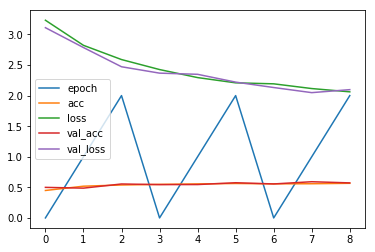

In [29]:
pd.read_csv(model_name+'/logs.csv').plot()
plt.show()

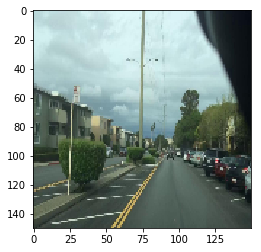

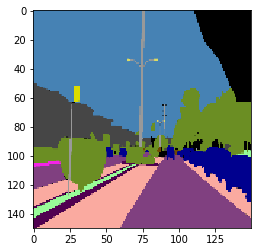

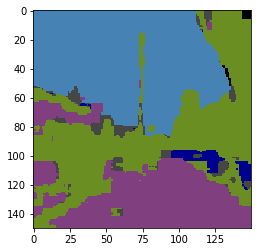

In [28]:
index = 10
inp = np.zeros((1,input_Shape[0],input_Shape[1],3))
inp[0] = X_test[index]
predicted = autoencoder.predict(inp)
out = map_img(predicted[0])
plt.imshow(X_test[index])
plt.show()
os.listdir()
lb = plt.imread('./gt/' + x_test[index])
plt.imshow(cv2.resize(lb,(input_Shape[0],input_Shape[1])))
plt.show()
plt.imshow(out)
plt.show()
